In [1]:
import torch
import torch.nn.functional as F
from torch import Tensor
import random
from mynn import *
import numpy as NP
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
from collections import Counter


rndSeed = 42
contextSize = 3
trRatio = 0.8
devRatio = 0.9
embeddingDims = 10
hiddenLayerSize = 300
trainingBatchSize = 32
rndSeed2 = 2147483647
g = torch.Generator().manual_seed(rndSeed2)
gSampling = torch.Generator().manual_seed(rndSeed2 + 10)


words = readFileSplitByLine('names.txt')
random.seed(rndSeed)
random.shuffle(words)
print('first few words:\t', words[:5])

lenWords = len(words);
print('lenWords:\t', lenWords)

allPossibleChars = sorted(list(set(''.join(words))))
print('allPossibleChars:\t', allPossibleChars)

stoi = sToI(allPossibleChars)
print('stoi:\t', stoi)

itos = iToS(stoi)
print('itos:\t', itos)

vocabularySize = len(itos)
print('vocabularySize:\t', vocabularySize)

lenTrain = int(trRatio * lenWords)
trWords = words[:lenTrain]
trX, trY = buildDataSet(trWords, contextSize, stoi, itos)
print('data set training:\t', lenTrain, trX.shape, trY.shape, trWords[:3])

endDev = int(devRatio * lenWords)
devWords = words[lenTrain:endDev];
devX, devY = buildDataSet(devWords, contextSize, stoi, itos)
print('data set dev:\t', endDev - lenTrain, devX.shape, devY.shape, devWords[:3])

lenTest = lenWords - endDev
tstWords = words[endDev:]
tstX, tstY = buildDataSet(tstWords, contextSize, stoi, itos)
print('data set test:\t', lenTest, tstX.shape, tstY.shape, tstWords[:3])

np = makeNetwork(g, vocabularySize, embeddingDims, contextSize, hiddenLayerSize)
print('parametersCount:\t', sum(p.nelement() for p in np.all))

@torch.no_grad()
def trLoss(): return getLoss(np, np.C[trX], trY)

@torch.no_grad()
def devLoss(): return getLoss(np, np.C[devX], devY)

@torch.no_grad()
def tstLoss(): return getLoss(np, np.C[tstX], tstY)

class Losses:
    tr: Loss
    dev: Loss
    tst: Loss

def getLosses() -> Losses:
    l = Losses()
    l.tr = trLoss()
    l.dev = devLoss()
    l.tst = tstLoss()
    return l

def printLosses():
    losses = getLosses()
    l1 = f'{losses.tr.loss.item():>10.4f}'
    l2 = f'{losses.dev.loss.item():>10.4f}'
    l3 = f'{losses.tst.loss.item():>10.4f}'
    print(f'losses: {l1}, {l2}, {l3}')

def calculate_entropy(dataset):
    # Flatten the dataset and create a frequency distribution
    frequency_distribution = Counter(''.join(dataset))
    
    # Normalize the frequency distribution to get a probability distribution
    probabilities = NP.array(list(frequency_distribution.values())) / sum(frequency_distribution.values())
    
    print('probabilities ', probabilities)
    # Calculate the entropy
    entropy = -torch.sum(torch.tensor(probabilities) * torch.log2(torch.tensor(probabilities)))
    
    return entropy

#print('xxxx ', calculate_entropy(words))

trXLength = trX.shape[0]
maxTrainingSteps = (trXLength // trainingBatchSize)
print ('maxTrainingSteps: \t', maxTrainingSteps)

lr = 0.1;
lre = torch.linspace(-3, 0, maxTrainingSteps)
lrs = 10 ** lre
lrAtIx: list[float] = []
stepIx: list[int] = []
lossAtIx: list[float] = []
logLossAtIx: list[float] = []
fr: ForwardPassResult = ForwardPassResult()

i = 0
for repeat in range(10):
    
    print(f'{repeat:>3}, {i:>10}: ', end='')
    printLosses()

    for start in range(0, trXLength, trainingBatchSize):
        i += 1
        end = min(start + trainingBatchSize, trXLength)
        #miniBatchIxs = torch.arange(start, end)
        miniBatchIxs = torch.randint(0, trXLength, (trainingBatchSize,), generator=g)
        fr = forwardPass(np, trX, trY, miniBatchIxs)

        backwardPass(np.all, fr.loss)
        
        stepIx.append(i)
        lossAtIx.append(fr.loss.item())
        logLossAtIx.append(fr.loss.log10().item())

        #lr = lrs[i].item()
        #lrAtIx.append(lrs[i].item())
        
        updateNet(np.all, i, lr)

printLosses()

#bestLr = lrs[findLowestIndex(lossAtIx)].item();
#print('best learning rate:\t', bestLr)
print('emb.shape:\t', fr.emb.shape)
print('h.shape:\t', fr.h.shape)
print('logits.shape:\t', fr.logits.shape)



first few words:	 ['yuheng', 'diondre', 'xavien', 'jori', 'juanluis']
lenWords:	 32033
allPossibleChars:	 ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
stoi:	 {'.': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
itos:	 {0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}
vocabularySize:	 27
data set training:	 25626 torch.Size([182625, 3]) torch.Size([182625]) ['yuheng', 'diondre', 'xavien']
data set dev:	 3203 torch.Size([22655, 3]) torch.Size([22655]) ['amay', 'aytana', 'jenevi']
data set test:	 3204 torch.Size([22866, 3]) torch.Size([22866]) ['

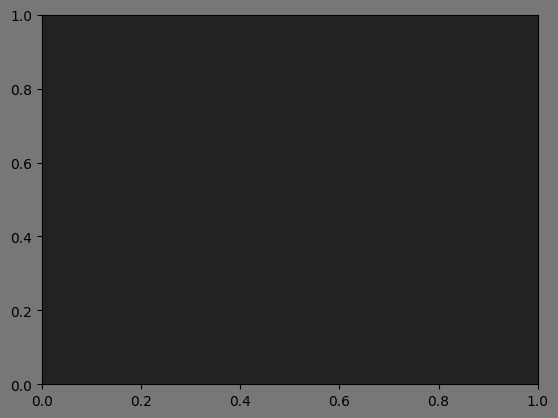

In [3]:
fig, ax = plt.subplots()
fig.set_facecolor('#777777')
ax.set_facecolor('#222222')
#ax.plot(lrAtIx, lossAtIx)
plt.show()

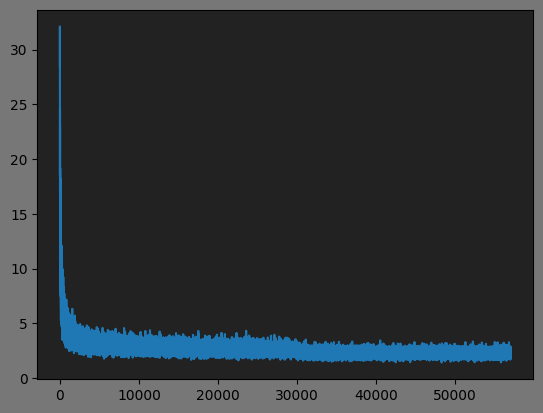

In [4]:
fig, ax = plt.subplots()
fig.set_facecolor('#777777')
ax.set_facecolor('#222222')
ax.plot(stepIx, lossAtIx)
plt.show()

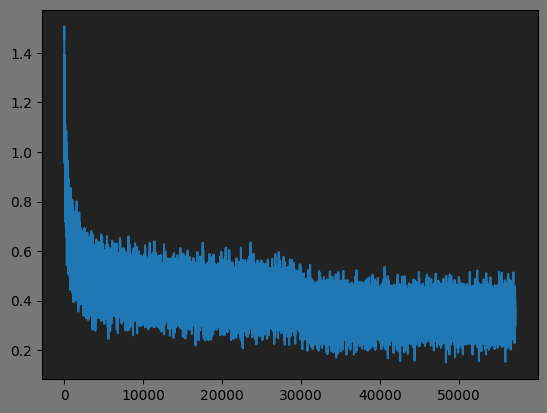

In [5]:
fig, ax = plt.subplots()
fig.set_facecolor('#777777')
ax.set_facecolor('#222222')
ax.plot(stepIx, logLossAtIx)
plt.show()

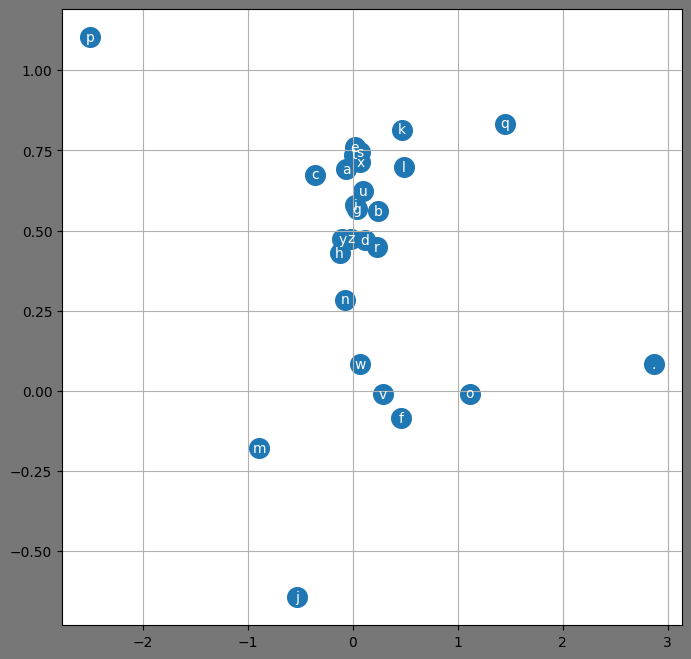

In [6]:
dim = 0
fig = plt.figure(figsize=(8,8))
fig.set_facecolor('#777777')
sc = plt.scatter(np.C[:, dim].data, np.C[:,dim + 1].data, s=200)
for i in range(np.C.shape[0]):
    plt.text(np.C[i, dim].item(), np.C[i, dim + 1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')

In [11]:
sample(np, gSampling, contextSize, itos, 20)

mellakephrro.
sxasty.
damarien.
gyanna.
tud.
aive.
dih.
virley.
jaseranenialorilya.
iimarilon.
el.
jannylony.
pore.
nove.
makerz.
bryk.
ames.
thavia.
daete.
anea.


In [8]:
np.C.shape, trX.shape, np.C[trX].shape, np.C[:5], trX[:5], np.C[trX][:5]

(torch.Size([27, 10]),
 torch.Size([182625, 3]),
 torch.Size([182625, 3, 10]),
 tensor([[ 2.8670,  0.0843, -1.0258, -1.7340,  0.9615, -0.6870, -2.1771,  0.4550,
           0.4165,  0.4439],
         [-0.0616,  0.6908, -0.6609,  0.0284,  1.6256,  4.2039,  1.4172, -2.7863,
           0.3496, -0.7756],
         [ 0.2427,  0.5602, -0.4091,  0.0218,  0.3417,  0.8556,  0.7457, -0.2347,
          -0.3333, -0.6309],
         [-0.3570,  0.6746, -0.7032,  0.7939, -0.1277, -0.3598, -1.2858,  0.7157,
          -1.1961,  0.6743],
         [ 0.1184,  0.4704, -0.2647,  0.0150,  0.0643,  0.5963,  0.5088, -0.3495,
          -0.3893, -0.5983]], grad_fn=<SliceBackward0>),
 tensor([[ 0,  0,  0],
         [ 0,  0, 25],
         [ 0, 25, 21],
         [25, 21,  8],
         [21,  8,  5]]),
 tensor([[[ 2.8670,  0.0843, -1.0258, -1.7340,  0.9615, -0.6870, -2.1771,
            0.4550,  0.4165,  0.4439],
          [ 2.8670,  0.0843, -1.0258, -1.7340,  0.9615, -0.6870, -2.1771,
            0.4550,  0.4165,  0.44

In [9]:
# Let's suppose these are your lists
C = [
[ 0.8774, -0.6801],
         [ 0.1651, -0.5025],
         [ 0.2769, -0.3570],
         [-0.8820,  0.3902],
         [-0.4824,  0.8744],
         [-0.3190,  0.7807],
         [-0.0100, -0.3401],
         [ 0.9975,  2.8280],
         [ 0.9623, -1.3172],
         [ 0.2180, -0.3820],
         [ 0.6139, -0.4287],
         [-0.7386,  0.5880],
         [-0.3088,  0.9816],
         [ 0.3907, -0.4174],
         [-0.7380,  0.5205],
         [-0.5288,  0.7074],
         [-0.3956,  0.9625],
         [-0.3802, -0.3504],
         [-0.2861,  0.7589],
         [ 0.5309, -0.5105],
         [-0.0922, -0.6410],
         [-0.3823,  0.9899],
         [ 0.0965, -0.5708],
         [-0.8582, -1.3429],
         [-0.4960,  0.2842],
         [-0.6105,  0.1336],
         [-0.2623,  0.2942]
]
trX = [
    [0, 0, 0],
    [0, 0, 22],
    [0, 22, 9],
    [22, 9, 15],
    [9, 15, 12],
    # ... More values
]

# We create a new list to hold the result
result = []

# We loop over each element in trX
for i in range(len(trX)):
    temp = []
    # Then we loop over each value in the element
    for j in range(len(trX[i])):
        # We use the value as an index to get the corresponding data from C
        temp.append(C[trX[i][j]])
    # We add the result to our new list
    result.append(temp)

# Let's print the first 5 elements of the result list
for i in range(5):
    print(result[i])

[[0.8774, -0.6801], [0.8774, -0.6801], [0.8774, -0.6801]]
[[0.8774, -0.6801], [0.8774, -0.6801], [0.0965, -0.5708]]
[[0.8774, -0.6801], [0.0965, -0.5708], [0.218, -0.382]]
[[0.0965, -0.5708], [0.218, -0.382], [-0.5288, 0.7074]]
[[0.218, -0.382], [-0.5288, 0.7074], [-0.3088, 0.9816]]
